In [1]:

import random
import warnings

import cv2
import numpy as np
from keras import layers, models
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.models import Model
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
import tensorflow as tf
# tf.keras.mixed_precision.set_dtype_policy('mixed_float16')
# tf.keras.backend.set_floatx('float32')

from coord import CoordinateChannel2D

In [2]:
class CNN:
    @staticmethod
    def build(width, height, depth, classes):
        inputShape = (height, width, depth)
        input_layer = Input(shape=inputShape)
        
        # coord1 = CoordinateChannel2D()(input_layer)
        conv1 = Conv2D(32, (3, 3), activation='relu')(input_layer)
        pool1 = MaxPooling2D(2, 2)(conv1)
        drop1 = Dropout(0.2)(pool1)
        
        # coord2 = CoordinateChannel2D()(drop1)
        conv2 = Conv2D(32, (3, 3), activation='relu')(drop1)
        pool2 = MaxPooling2D(2, 2)(conv2)
        drop2 = Dropout(0.2)(pool2)
        
        # coord3 = CoordinateChannel2D()(drop2)
        conv3 = Conv2D(64, (3, 3), activation='relu')(drop2)
        pool3 = MaxPooling2D(2, 2)(conv3)
        drop3 = Dropout(0.2)(pool3)
        
        flat = Flatten()(drop3)
        
        dense1 = Dense(128, activation='relu')(flat)
        
        output_layer = Dense(classes, activation='softmax')(dense1)
        
        model = Model(inputs=input_layer, outputs=output_layer)
        
        return model

In [3]:
def train_cnn(train_images, train_labels, val_images=np.array([]), val_labels=np.array([]), epochs=5):
    model = CNN.build(width=120, height=400, depth=3, classes=8)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])  #98.97 - adam 99.23 - rmsprop
    model.summary()
    if val_images.size != 0 and val_labels.size != 0:
        model.fit(train_images, train_labels, epochs=epochs, batch_size=32, validation_data=(val_images, val_labels))
    else:
        model.fit(train_images, train_labels, epochs=epochs, batch_size=32)
    return model

In [4]:
def evalute_cnn(model, test_images, test_labels):
    test_loss, test_acc = model.evaluate(test_images, test_labels)
    print(f'[INFO] Loss:{test_loss:.4f} Test accuracy: {(test_acc * 100):.4f}')

In [5]:
def calculate_f1_score(model, test_images, test_labels):
    test_prob = model.predict(test_images)
    test_pred = test_prob.argmax(axis=-1)
    f1 = f1_score(test_labels, test_pred, average='weighted')
    print(f'[INFO] F1-Score is:{f1:.4f}')
    return f1

In [6]:
import functools

@functools.lru_cache(maxsize=1)
def get_i_j_coord_arrays(shape1, shape2):
    i_coord_layer_og = [[i] * shape2 for i in range(shape1)]
    i_coord_layer = []
    for sublist in i_coord_layer_og:
        i_coord_layer.append([[element] for element in sublist])
    i_coord_layer = np.array(i_coord_layer)
    i_coord_layer = i_coord_layer / max(shape1, shape2)
    
    j_coord_layer_og = [[i for i in range(shape2)] for j in range(shape1)]
    j_coord_layer = []
    for sublist in j_coord_layer_og:
        j_coord_layer.append([[element] for element in sublist])
    j_coord_layer = np.array(j_coord_layer)
    j_coord_layer = j_coord_layer / max(shape1, shape2)
    
    return i_coord_layer, j_coord_layer


def get_numpy_array_for_image(image_path):
    # print(image_path)
    img = cv2.imread(image_path)

    img_transformed = img[:, :, :1]

    img_transformed = 255 - img_transformed

    img_transformed = img_transformed / 255

    shape1 = img_transformed.shape[0]
    shape2 = img_transformed.shape[1]

    i_coord_layer, j_coord_layer = get_i_j_coord_arrays(shape1, shape2)

    img_coord = np.concatenate([img_transformed, i_coord_layer, j_coord_layer], axis=2)
    
    # Convert to float 16
    img_coord = img_coord.astype('float16')

    return img_coord
# def get_numpy_array_for_image(image_path):
#     # print(image_path)
#     img = cv2.imread(image_path)
# 
#     img_transformed = img[:, :, :1]
# 
#     img_transformed = 255 - img_transformed
# 
#     img_final = np.squeeze(img_transformed, axis=2)
# 
#     return img_final

In [7]:
import pandas as pd


def csv_to_array(file_path):
    df = pd.read_csv(file_path)
    return np.array(list(df['data_labels']))

In [8]:
import os

current_directory = os.getcwd()

os.chdir("D:/Pycharm Projects")

train_folder = rf"ThesisFinalData\larger_scaled_images_rolling_window_6_limit_90\train"

train_images = []

train_images_list = os.listdir(fr'{train_folder}\images')
train_images_list.sort(key=lambda x: int(x.split('_')[1]))

index = 0
for index, img in enumerate(train_images_list):
    print(index)
    index += 1
    train_images.append(get_numpy_array_for_image(rf'{train_folder}\images\{img}'))

train_images = np.array(train_images)

train_labels = csv_to_array(f'{train_folder}/train_data_labels_absolute_8_limit_90.csv')

test_folder = rf"ThesisFinalData\larger_scaled_images_rolling_window_6_limit_90\test"

test_images = []

test_images_list = os.listdir(fr'{test_folder}\images')
test_images_list.sort(key=lambda x: int(x.split('_')[1]))

index = 0
for index, img in enumerate(test_images_list):
    print(index)
    index += 1
    test_images.append(get_numpy_array_for_image(rf'{test_folder}\images\{img}'))

test_images = np.array(test_images)

test_labels = csv_to_array(f'{test_folder}/test_data_labels_absolute_8_limit_90.csv')

# os.chdir(current_directory)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [9]:
num_train_images = len(train_images)
print(f"number of training images: {num_train_images}")
train_images_order = list(range(num_train_images))
random.shuffle(train_images_order)
train_images_order = train_images_order[:num_train_images//2]
print(f"train images order {train_images_order}")
print(f"train images initial {train_images}")
print(f"train labels initial {train_labels}")
train_images = train_images[train_images_order]
train_labels = train_labels[train_images_order]
print(f"train images shuffled {train_images}")
print(f"train labels shuffled {train_labels}")

number of training images: 28044
train images order [22143, 19628, 20292, 27810, 10009, 14668, 12195, 11769, 10242, 4911, 17928, 9019, 15137, 15051, 24119, 15897, 24818, 24093, 12471, 14857, 6812, 857, 6496, 18460, 22559, 760, 16438, 18701, 2903, 23681, 18501, 13814, 4226, 16243, 15212, 21918, 25258, 1635, 13601, 5643, 25681, 16881, 28016, 4200, 15180, 5541, 11805, 21142, 365, 23563, 10577, 5164, 27818, 3086, 13252, 22809, 18745, 13220, 9207, 26038, 15711, 15835, 21529, 9808, 639, 22932, 15642, 422, 9638, 2591, 22883, 1096, 19343, 7374, 25647, 3876, 21661, 27190, 11234, 7653, 11262, 2479, 4667, 25638, 11518, 23677, 21340, 26200, 22341, 16589, 6662, 15297, 25481, 1594, 25861, 1971, 23724, 18937, 26619, 9358, 10290, 14397, 2420, 4370, 1631, 1199, 15703, 8948, 16192, 1422, 26942, 9978, 19688, 1312, 8432, 10041, 11810, 17775, 434, 18513, 17687, 3848, 16092, 22909, 23366, 12821, 24182, 9903, 15890, 21862, 17414, 12438, 20424, 9604, 15007, 13581, 3081, 18217, 9503, 27282, 2665, 22200, 23252,

In [10]:
print(f"number of training images: {len(train_images)}")
print(f"number of testing images: {len(test_images)}")

number of training images: 14022
number of testing images: 7012


In [11]:
print(f"number of training data labels {len(train_labels)}")
print(f"number of training data labels {len(test_labels)}")

number of training data labels 14022
number of training data labels 7012


In [12]:
import collections

print(collections.Counter(train_labels))

Counter({4.0: 4477, 3.0: 4097, 5.0: 1861, 2.0: 1658, 1.0: 618, 6.0: 575, 0.0: 436, 7.0: 300})


In [13]:
all_images_folder = rf"ThesisFinalData\larger_scaled_images_rolling_window_6_limit_90\all images"
all_grayscale_images = {file for file in os.listdir(all_images_folder) if file.endswith('grayscale.png')}

print(f"number of all images: {len(all_grayscale_images)}")
train_plus_test_set = set(train_images_list + test_images_list)
print(train_plus_test_set - all_grayscale_images)
assert train_plus_test_set == all_grayscale_images


number of all images: 35056
set()


In [14]:
print("image shape: ", train_images[0].shape)
print("label: ", train_labels[0])
train_images[0]

image shape:  (400, 120, 3)
label:  5.0


array([[[0.02353, 0.     , 0.     ],
        [0.02353, 0.     , 0.0025 ],
        [0.02353, 0.     , 0.005  ],
        ...,
        [0.02353, 0.     , 0.2925 ],
        [0.02353, 0.     , 0.295  ],
        [0.02353, 0.     , 0.2976 ]],

       [[0.     , 0.0025 , 0.     ],
        [0.     , 0.0025 , 0.0025 ],
        [0.     , 0.0025 , 0.005  ],
        ...,
        [0.     , 0.0025 , 0.2925 ],
        [0.     , 0.0025 , 0.295  ],
        [0.     , 0.0025 , 0.2976 ]],

       [[0.     , 0.005  , 0.     ],
        [0.     , 0.005  , 0.0025 ],
        [0.     , 0.005  , 0.005  ],
        ...,
        [0.     , 0.005  , 0.2925 ],
        [0.     , 0.005  , 0.295  ],
        [0.     , 0.005  , 0.2976 ]],

       ...,

       [[0.     , 0.9927 , 0.     ],
        [0.     , 0.9927 , 0.0025 ],
        [0.     , 0.9927 , 0.005  ],
        ...,
        [0.     , 0.9927 , 0.2925 ],
        [0.     , 0.9927 , 0.295  ],
        [0.     , 0.9927 , 0.2976 ]],

       [[0.     , 0.995  , 0.     ],
  

In [15]:
# (train_images, train_labels), (test_images, test_labels) = mnist.load_data()
train_images = train_images.reshape(train_images.shape[0], 400, 120, 3)
test_images = test_images.reshape(test_images.shape[0], 400, 120, 3)

# train_images, test_images = train_images / 255, test_images / 255

# train_images = train_images.astype('float16')
# test_images = test_images.astype('float16')


In [16]:
del all_grayscale_images
del train_plus_test_set
del train_images_list
del test_images_list

In [17]:
train_images

array([[[[0.02353, 0.     , 0.     ],
         [0.02353, 0.     , 0.0025 ],
         [0.02353, 0.     , 0.005  ],
         ...,
         [0.02353, 0.     , 0.2925 ],
         [0.02353, 0.     , 0.295  ],
         [0.02353, 0.     , 0.2976 ]],

        [[0.     , 0.0025 , 0.     ],
         [0.     , 0.0025 , 0.0025 ],
         [0.     , 0.0025 , 0.005  ],
         ...,
         [0.     , 0.0025 , 0.2925 ],
         [0.     , 0.0025 , 0.295  ],
         [0.     , 0.0025 , 0.2976 ]],

        [[0.     , 0.005  , 0.     ],
         [0.     , 0.005  , 0.0025 ],
         [0.     , 0.005  , 0.005  ],
         ...,
         [0.     , 0.005  , 0.2925 ],
         [0.     , 0.005  , 0.295  ],
         [0.     , 0.005  , 0.2976 ]],

        ...,

        [[0.     , 0.9927 , 0.     ],
         [0.     , 0.9927 , 0.0025 ],
         [0.     , 0.9927 , 0.005  ],
         ...,
         [0.     , 0.9927 , 0.2925 ],
         [0.     , 0.9927 , 0.295  ],
         [0.     , 0.9927 , 0.2976 ]],

        [[

In [18]:
train_images[0]

array([[[0.02353, 0.     , 0.     ],
        [0.02353, 0.     , 0.0025 ],
        [0.02353, 0.     , 0.005  ],
        ...,
        [0.02353, 0.     , 0.2925 ],
        [0.02353, 0.     , 0.295  ],
        [0.02353, 0.     , 0.2976 ]],

       [[0.     , 0.0025 , 0.     ],
        [0.     , 0.0025 , 0.0025 ],
        [0.     , 0.0025 , 0.005  ],
        ...,
        [0.     , 0.0025 , 0.2925 ],
        [0.     , 0.0025 , 0.295  ],
        [0.     , 0.0025 , 0.2976 ]],

       [[0.     , 0.005  , 0.     ],
        [0.     , 0.005  , 0.0025 ],
        [0.     , 0.005  , 0.005  ],
        ...,
        [0.     , 0.005  , 0.2925 ],
        [0.     , 0.005  , 0.295  ],
        [0.     , 0.005  , 0.2976 ]],

       ...,

       [[0.     , 0.9927 , 0.     ],
        [0.     , 0.9927 , 0.0025 ],
        [0.     , 0.9927 , 0.005  ],
        ...,
        [0.     , 0.9927 , 0.2925 ],
        [0.     , 0.9927 , 0.295  ],
        [0.     , 0.9927 , 0.2976 ]],

       [[0.     , 0.995  , 0.     ],
  

In [19]:
train_labels

array([5., 5., 1., ..., 5., 3., 4.])

In [20]:
print(list(train_labels).count(0))

436


In [21]:
test_labels

array([3., 4., 4., ..., 0., 5., 5.])

In [22]:
print(test_labels[-3:])

[0. 5. 5.]


In [23]:
train_images_dummy = train_images[:9]
test_images_dummy = train_images[:9]
train_labels_dummy = train_labels[:9]
test_labels_dummy = train_labels[:9]
print(train_images_dummy)
print(train_labels_dummy)
print(test_images_dummy)
print(test_labels_dummy)

[[[[0.02353 0.      0.     ]
   [0.02353 0.      0.0025 ]
   [0.02353 0.      0.005  ]
   ...
   [0.02353 0.      0.2925 ]
   [0.02353 0.      0.295  ]
   [0.02353 0.      0.2976 ]]

  [[0.      0.0025  0.     ]
   [0.      0.0025  0.0025 ]
   [0.      0.0025  0.005  ]
   ...
   [0.      0.0025  0.2925 ]
   [0.      0.0025  0.295  ]
   [0.      0.0025  0.2976 ]]

  [[0.      0.005   0.     ]
   [0.      0.005   0.0025 ]
   [0.      0.005   0.005  ]
   ...
   [0.      0.005   0.2925 ]
   [0.      0.005   0.295  ]
   [0.      0.005   0.2976 ]]

  ...

  [[0.      0.9927  0.     ]
   [0.      0.9927  0.0025 ]
   [0.      0.9927  0.005  ]
   ...
   [0.      0.9927  0.2925 ]
   [0.      0.9927  0.295  ]
   [0.      0.9927  0.2976 ]]

  [[0.      0.995   0.     ]
   [0.      0.995   0.0025 ]
   [0.      0.995   0.005  ]
   ...
   [0.      0.995   0.2925 ]
   [0.      0.995   0.295  ]
   [0.      0.995   0.2976 ]]

  [[0.4275  0.9976  0.     ]
   [0.4275  0.9976  0.0025 ]
   [0.4275  0.9976  

In [24]:
# model = train_cnn(train_images_dummy,train_labels_dummy,test_images_dummy,test_labels_dummy, epochs = 5)
# print(model.predict(test_images_dummy))
# evalute_cnn(model,test_images_dummy,test_labels_dummy)
# calculate_f1_score(model,test_images_dummy,test_labels_dummy)
model = train_cnn(train_images, train_labels, test_images, test_labels, epochs=15)
# model = train_cnn(train_images,train_labels)
evalute_cnn(model, test_images, test_labels)
calculate_f1_score(model, test_images, test_labels)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 400, 120, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 398, 118, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 199, 59, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 199, 59, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 197, 57, 32)    │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 98, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 98, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 96, 26, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 48, 13, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 48, 13, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 39936)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     5,111,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,141,608 (19.61 MB)

 Trainable params: 5,141,608 (19.61 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
439/439 ━━━━━━━━━━━━━━━━━━━━ 211s 473ms/step - accuracy: 0.3005 - loss: 1.8372 - val_accuracy: 0.3068 - val_loss: 1.7352
Epoch 2/15
439/439 ━━━━━━━━━━━━━━━━━━━━ 194s 442ms/step - accuracy: 0.3200 - loss: 1.6877 - val_accuracy: 0.3093 - val_loss: 1.7385
Epoch 3/15
439/439 ━━━━━━━━━━━━━━━━━━━━ 196s 447ms/step - accuracy: 0.3240 - loss: 1.6752 - val_accuracy: 0.2998 - val_loss: 1.7197
Epoch 4/15
439/439 ━━━━━━━━━━━━━━━━━━━━ 190s 432ms/step - accuracy: 0.3279 - loss: 1.6670 - val_accuracy: 0.2948 - val_loss: 1.7286
Epoch 5/15
439/439 ━━━━━━━━━━━━━━━━━━━━ 195s 444ms/step - accuracy: 0.3510 - loss: 1.6126 - val_accuracy: 0.2968 - val_loss: 1.7383
Epoch 6/15
439/439 ━━━━━━━━━━━━━━━━━━━━ 191s 435ms/step - accuracy: 0.3724 - loss: 1.5731 - val_accuracy: 0.2973 - val_loss: 1.7393
Epoch 7/15
439/439 ━━━━━━━━━━━━━━━━━━━━ 193s 439ms/step - accuracy: 0.3913 - loss: 1.5238 - val_accuracy: 0.2968 - val_loss: 1.8139
Epoch 8/15
439/439 ━━━━━━━━━━━━━━━━━━━━ 193s 440ms/step - accuracy: 0.4435 -

0.23064245534982683

In [25]:
model_predictions = model.predict(test_images)

220/220 ━━━━━━━━━━━━━━━━━━━━ 23s 106ms/step


In [26]:
predicted_test_labels = []

for row in model_predictions:
    max_value_in_row = max(row)
    predicted_test_label = list(row).index(max_value_in_row)
    predicted_test_labels.append(predicted_test_label)

predicted_test_labels

[3,
 4,
 4,
 4,
 4,
 2,
 3,
 4,
 3,
 3,
 2,
 3,
 4,
 1,
 4,
 3,
 4,
 4,
 4,
 5,
 6,
 3,
 4,
 2,
 4,
 4,
 4,
 4,
 3,
 4,
 4,
 2,
 3,
 3,
 2,
 3,
 2,
 5,
 4,
 3,
 4,
 4,
 3,
 4,
 4,
 2,
 4,
 3,
 3,
 3,
 5,
 3,
 3,
 4,
 4,
 4,
 3,
 5,
 3,
 3,
 3,
 4,
 2,
 3,
 4,
 4,
 2,
 2,
 3,
 3,
 4,
 4,
 4,
 5,
 5,
 4,
 3,
 4,
 4,
 4,
 4,
 3,
 4,
 3,
 4,
 4,
 3,
 5,
 4,
 4,
 4,
 4,
 4,
 3,
 4,
 4,
 3,
 4,
 4,
 4,
 3,
 4,
 3,
 4,
 4,
 3,
 4,
 2,
 2,
 1,
 4,
 3,
 5,
 4,
 4,
 3,
 5,
 3,
 4,
 3,
 3,
 4,
 4,
 4,
 4,
 4,
 4,
 2,
 6,
 4,
 3,
 2,
 6,
 3,
 5,
 4,
 4,
 3,
 5,
 3,
 3,
 3,
 2,
 4,
 4,
 5,
 4,
 3,
 3,
 4,
 4,
 4,
 4,
 3,
 3,
 3,
 4,
 4,
 4,
 4,
 4,
 4,
 3,
 5,
 3,
 5,
 3,
 3,
 3,
 3,
 4,
 3,
 2,
 5,
 3,
 2,
 4,
 5,
 7,
 4,
 3,
 3,
 3,
 3,
 4,
 5,
 4,
 3,
 3,
 4,
 3,
 2,
 2,
 5,
 5,
 3,
 3,
 3,
 4,
 3,
 3,
 3,
 4,
 5,
 2,
 4,
 3,
 4,
 3,
 3,
 4,
 4,
 4,
 3,
 4,
 3,
 4,
 2,
 3,
 4,
 5,
 4,
 1,
 4,
 1,
 4,
 3,
 4,
 5,
 3,
 6,
 4,
 3,
 3,
 2,
 5,
 4,
 2,
 2,
 5,
 4,
 3,
 3,
 3,
 1,
 4,
 2,
 3,
 1,
 4,


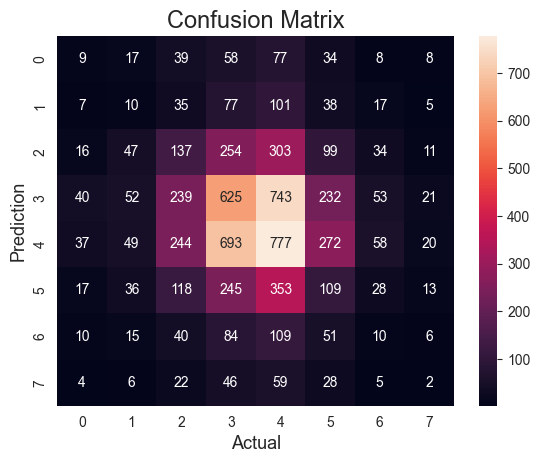

In [27]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(test_labels, predicted_test_labels)

sns.heatmap(cm,
            annot=True,
            fmt='g',
            xticklabels=[0, 1, 2, 3, 4, 5, 6, 7],
            yticklabels=[0, 1, 2, 3, 4, 5, 6, 7])
plt.ylabel('Prediction', fontsize=13)
plt.xlabel('Actual', fontsize=13)
plt.title('Confusion Matrix', fontsize=17)
plt.show()
# Why are these values different from the ones calculated above ?

# TP - predicted 3,4 actual 3,4 = 4655
# TN - predicted 0,1,2,5,6,7 actual 0,1,2,5,6,7 = 74 + 70 + 129 + 98 = 371
# FP - predicted 3,4 actual 0,1,2,5,6,7 = 89 + 167 = 256
# FN - predicted 0,1,2,5,6,7 actual 3,4 = 1768 + 1849 = 3617

# total = 4655 + 371 + 256 + 3617 = 8899

# accuracy = (4655 + 371) / 8899 = 0.56
# recall = 4655 / (4655 + 3617) = 0.56
# F1 = 2 * (0.56 * 0.56) / (0.56 + 0.56) = 0.56

In [28]:
def crossover(c1, c2, min_width=1, h_lower_bound=2, h_upper_bound=10):
    height, width, depth = c1.shape
    start_h = np.random.randint(1, height // 2 + 1)
    end_h = np.random.randint(start_h + h_lower_bound, min(start_h + h_upper_bound, height))
    start_w = np.random.randint(0, width - min_width)
    end_w = np.random.randint(start_w + min_width, width)
    c1_sliced = c1.copy()
    c2_sliced = c2.copy()
    c1_sliced[start_h:end_h, start_w:end_w, :] = c2[start_h:end_h, start_w:end_w, :]
    c2_sliced[start_h:end_h, start_w:end_w, :] = c1[start_h:end_h, start_w:end_w, :]
    return c1_sliced, c2_sliced

In [29]:
org1 = train_images[np.random.randint(0, len(train_images))]
org2 = train_images[np.random.randint(0, len(train_images))]
c1_crossover, c2_crossover = crossover(org1, org2)
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(org1.squeeze(), cmap='gray')
plt.title('Original Image 1')
plt.subplot(1, 2, 2)
plt.imshow(org2.squeeze(), cmap='gray')
plt.title('Original Image 2')
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(c1_crossover.squeeze(), cmap='gray')
plt.title('Crossover Image 1')
plt.subplot(1, 2, 2)
plt.imshow(c2_crossover.squeeze(), cmap='gray')
plt.title('Crossover Image 2')
plt.show()

ValueError: arrays must be of dtype byte, short, float32 or float64

<Figure size 1000x500 with 2 Axes>

ValueError: arrays must be of dtype byte, short, float32 or float64

<Figure size 1000x500 with 2 Axes>

In [30]:
def mutation(m, d=5):
    mutated_image = m.copy()
    step = np.random.randint(-d, d + 1) / 255.
    mask = np.random.choice([True, False], size=mutated_image.shape)
    mutated_image[mask] += step
    return mutated_image

In [31]:
image = train_images[np.random.randint(0, len(train_images))]
mutated_image = mutation(image)
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image.squeeze(), cmap='gray')
plt.title('Original Image')
plt.subplot(1, 2, 2)
plt.imshow(mutated_image.squeeze(), cmap='gray')
plt.title('Mutated Image')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


ValueError: arrays must be of dtype byte, short, float32 or float64

<Figure size 1000x500 with 2 Axes>

In [32]:
def anneal(alpha, mask_a, d=2, lower_bound=2, upper_bound=10):
    alpha = alpha.copy()
    mask_b = np.random.choice([True, False], size=alpha.shape)
    mask = mask_a ^ mask_b
    step = np.random.randint(-d, d + 1, size=alpha.shape) / 225.
    start_h = np.random.randint(0, lower_bound)
    end_h = np.random.randint(alpha.shape[0] - upper_bound, alpha.shape[0])
    start_w = np.random.randint(0, lower_bound)
    end_w = np.random.randint(alpha.shape[1] - upper_bound, alpha.shape[1])
    masksliced = np.zeros(alpha.shape, dtype=bool)
    masksliced[start_h:end_h, start_w:end_w] = mask[start_h:end_h, start_w:end_w]
    # print(masksliced.shape)
    # print(alpha.shape)
    alpha[masksliced] += step[masksliced]
    return alpha

In [33]:
image = train_images[np.random.randint(0, len(train_images))]
mask_a = np.random.choice([True, False], size=image.shape)
anneal_image = anneal(image, mask_a)
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image.squeeze(), cmap='gray')
plt.title('Original Image')
plt.subplot(1, 2, 2)
plt.imshow(anneal_image.squeeze(), cmap='gray')
plt.title('Image with Annealing')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


ValueError: arrays must be of dtype byte, short, float32 or float64

<Figure size 1000x500 with 2 Axes>

In [34]:
def calculate_recall(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    # print(y_test,y_pred_classes)
    recall = recall_score(y_test, y_pred_classes, average='weighted')
    # print(recall)
    return recall

In [35]:
def fitness(X, Y, alpha_population, model, lambda_value=0.1):
    fitness_values = []
    for alpha, alpha_label in alpha_population:
        # print(alpha.shape)
        # print(alpha_label.shape)      
        # X_fitness = np.concatenate([X, alpha], axis=0)
        # Y_fitness = np.concatenate([Y, alpha_label], axis=0)
        # error = lambda_value * calculate_recall(model,X_fitness,Y_fitness)
        error = lambda_value * calculate_recall(model, alpha, alpha_label)
        alpha_fitness = 1 + error - np.linalg.norm(alpha)
        # print(error,np.linalg.norm(alpha),alpha_fitness)
        fitness_values.append(abs(np.max(alpha_fitness)))
    # best_index = np.argmax(fitness_values)
    # print(best_index)
    return fitness_values  #if needed put this too alpha_population[best_index]

In [36]:
X_sample = train_images[:4]
y_sample = train_labels[:4]
# print(X_sample.shape)
# print(y_sample.shape)
alpha_population_sample = [(np.expand_dims(x, axis=0), np.array([y])) for x, y in zip(X_sample, y_sample)]
# alpha_population_sample = [(np.random.rand(1,28, 28, 1), np.random.randint(0, 5, size=(1,))) for _ in range(3)]
# print(alpha_population_sample)
fitness_values = fitness(X_sample, y_sample, alpha_population_sample, model)
print("Fitness values for the sample alpha population:")
print(fitness_values)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Fitness values for the sample alpha population:
[134.775, 138.65, 137.65, 133.025]


In [37]:
def selection(parents, z=0.5):
    fitness_values = fitness(train_images, train_labels, parents, model)
    num_parents = len(parents)
    num_offspring = int(num_parents * z)
    selected_indices = np.random.choice(num_parents, num_offspring, replace=False,
                                        p=fitness_values / np.sum(fitness_values))
    offspring = [parents[i] for i in selected_indices]
    parents_next_gen = [parents[i] for i in range(num_parents) if i not in selected_indices]
    return parents_next_gen, offspring

In [38]:
# X_sample = train_images[:5]
# y_sample = train_labels[:5]
# model = train_cnn(X_sample, y_sample)
# maxpayoff = 0
# exitloop = False
# population = [(np.expand_dims(x, axis=0),np.array([y])) for x,y in zip(X_sample, y_sample)]
# # print(population)
# F_Xtrain = fitness(X_sample, y_sample, population,model)
# print(F_Xtrain)
# gen = 0

# best_index = np.argmax(F_Xtrain)
# print(best_index)
# acurr, currpayoff = population[best_index], F_Xtrain[best_index]  # what is the max show with the fitness example and what is this acurr
# # print(acurr[0],acurr[1])
# print(currpayoff)
# X_sample = np.concatenate([X_sample, acurr[0]], axis=0)
# y_sample = np.concatenate([y_sample, acurr[1]], axis=0)
# model = train_cnn(X_sample, y_sample) 

In [39]:
def twoplayergame_ga(Xtrain, Ytrain, maxiter=100):
    model = train_cnn(Xtrain, Ytrain)
    exitloop = False
    population = [(np.expand_dims(x, axis=0), np.array([y])) for x, y in zip(Xtrain, Ytrain)]
    F_Xtrain = fitness(Xtrain, Ytrain, population, model)
    maxpayoff = np.max(F_Xtrain)
    gen = 0
    while gen < maxiter and not exitloop:
        best_index = np.argmax(F_Xtrain)
        # print(F_Xtrain)
        acurr, currpayoff = population[best_index], F_Xtrain[best_index]
        Xcurr = np.concatenate([Xtrain, acurr[0]], axis=0)
        Ycurr = np.concatenate([Ytrain, acurr[1]], axis=0)
        model = train_cnn(Xcurr, Ycurr, epochs=1)
        print("The currpayoff is :", currpayoff)
        if abs(currpayoff - maxpayoff) < 0.1:  # the currpayoff issue is coming
            maxpayoff = currpayoff
            parents, offspring = selection(population, 0.5)

            new_offspring = []
            for i in range(0, len(offspring) - 1, 2):
                child1, child2 = crossover(np.squeeze(offspring[i][0], axis=0), np.squeeze(offspring[i + 1][0], axis=0))
                new_offspring.append((child1, offspring[i][1]))
                new_offspring.append((child2, offspring[i + 1][1]))

            curr_offspring = []
            for mutant, label in new_offspring:
                curr_offspring.append((np.expand_dims(mutation(mutant), axis=0), label))

            curr_population = parents + curr_offspring
            population = curr_population.copy()
            F_Xtrain = fitness(Xtrain, Ytrain, population, model)
        else:
            exitloop = True

        gen += 1

    final_index = np.argmax(F_Xtrain)
    acurr, maxpayoff = population[final_index], F_Xtrain[final_index]
    return acurr

In [40]:
warnings.filterwarnings('ignore')
X_sample = train_images[:5]
y_sample = train_labels[:5]
acurr = twoplayergame_ga(X_sample, y_sample)
print(acurr[1])
plt.imshow(acurr[0].squeeze(), cmap='gray')

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 400, 120, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 398, 118, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 199, 59, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 199, 59, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 197, 57, 32)    │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 98, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 98, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 96, 26, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 48, 13, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 48, 13, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 39936)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     5,111,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,141,608 (19.61 MB)

 Trainable params: 5,141,608 (19.61 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.2000 - loss: 2.0547
Epoch 2/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.4000 - loss: 3.2364
Epoch 3/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.2000 - loss: 2.6666
Epoch 4/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.4000 - loss: 1.7749
Epoch 5/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.2000 - loss: 1.6618
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 400, 120, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 398, 118, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 199, 59, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 199, 59, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 197, 57, 32)    │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 98, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 98, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 96, 26, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 48, 13, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 48, 13, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 39936)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │     5,111,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,141,608 (19.61 MB)

 Trainable params: 5,141,608 (19.61 MB)

 Non-trainable params: 0 (0.00 B)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.1667 - loss: 2.0255
The currpayoff is : 138.65
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 400, 120, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 398, 118, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 199, 59, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 199, 59, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 197, 57, 32)    │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 98, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 98, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 96, 26, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 48, 13, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 48, 13, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 39936)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │     5,111,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,141,608 (19.61 MB)

 Trainable params: 5,141,608 (19.61 MB)

 Non-trainable params: 0 (0.00 B)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.3333 - loss: 1.9933


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


The currpayoff is : 140.65
[5.]


Error in callback <function _draw_all_if_interactive at 0x0000026E0C43F560> (for post_execute), with arguments args (),kwargs {}:


ValueError: arrays must be of dtype byte, short, float32 or float64

ValueError: arrays must be of dtype byte, short, float32 or float64

<Figure size 640x480 with 1 Axes>

In [41]:
def twoplayergame_sa(Xtrain, Ytrain):
    model = train_cnn(Xtrain, Ytrain)
    maxpayoff = 0
    exitloop = False
    Tmax = 10
    Tmin = 5
    v = 5  # this should be 50
    p = 0.6
    mask = np.random.choice([True, False], size=Xtrain[0].shape)
    Tcurr = Tmax
    population = [(np.expand_dims(x, axis=0), np.array([y])) for x, y in zip(Xtrain, Ytrain)]
    random.shuffle(population)
    pop_size = len(population) // 3
    ac = population[:pop_size].copy()
    ag = population[pop_size:2 * pop_size].copy()
    an = population[2 * pop_size:].copy()
    evalc = fitness(Xtrain, Ytrain, ac, model)
    maxpayoff = max(fitness(Xtrain, Ytrain, ag, model))
    while not exitloop:
        evalg = fitness(Xtrain, Ytrain, ag, model)
        curr_index = np.argmax(evalg)
        currpayoff = evalg[curr_index]
        print("The current Payoff is:", currpayoff)
        if abs(currpayoff - maxpayoff) < 0.1:
            maxpayoff = currpayoff
            while Tcurr >= Tmin:
                i = 1
                while i <= v:
                    temp = []
                    for ele, label in ac:
                        temp.append((np.expand_dims(anneal(np.squeeze(ele, axis=0), mask), axis=0), label))
                    an = temp.copy()
                    evaln = fitness(Xtrain, Ytrain, an, model)
                    print(max(evaln), max(evalc), max(evalg))
                    if max(evaln) > max(evalc):
                        ac = an.copy()
                        evalc = evaln.copy()
                        if max(evalg) < max(evaln):
                            ag = an.copy()
                            evalg = evaln.copy()
                    else:
                        if np.random.random() <= np.exp((max(evaln) - max(evalc)) / Tcurr):
                            ac = an.copy()
                            evalc = evaln.copy()
                    i += 1
                Tcurr *= p
            ag = ac.copy()
        else:
            exitloop = True
    return ag[np.argmax(fitness(Xtrain, Ytrain, ag, model))]



In [42]:
X_sample = train_images[:10]
y_sample = train_labels[:10]
ag = twoplayergame_sa(X_sample, y_sample)
# print(ag)
print(ag[1])
plt.imshow(ag[0].squeeze(), cmap='gray')

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 400, 120, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 398, 118, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 199, 59, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 199, 59, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 197, 57, 32)    │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 98, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 98, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 96, 26, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 48, 13, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 48, 13, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 39936)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │     5,111,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,141,608 (19.61 MB)

 Trainable params: 5,141,608 (19.61 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.1000 - loss: 2.1925
Epoch 2/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - accuracy: 0.3000 - loss: 2.3623
Epoch 3/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - accuracy: 0.2000 - loss: 2.6018
Epoch 4/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - accuracy: 0.4000 - loss: 2.1466
Epoch 5/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - accuracy: 0.3000 - loss: 1.6283
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
The current Payoff is: 138.65
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
143.0 143.0 138.65
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[7.]


Error in callback <function _draw_all_if_interactive at 0x0000026E0C43F560> (for post_execute), with arguments args (),kwargs {}:


ValueError: arrays must be of dtype byte, short, float32 or float64

ValueError: arrays must be of dtype byte, short, float32 or float64

<Figure size 640x480 with 1 Axes>

In [43]:
def generate_manipulated_data(images, labels, A_s):
    if len(A_s) == 1:
        alphas, alpha_labels = A_s[0][0], A_s[0][1]
    else:
        alphas, alpha_labels = list(zip(*A_s))
        # print(alphas)
        alphas = np.squeeze(alphas, axis=1)
        # print(alphas.shape)
        # print(alpha_labels)
        alpha_labels = np.squeeze(alpha_labels)
        # print(alpha_labels.shape)
    X_manipulated = np.concatenate([images, alphas], axis=0)
    Y_manipulated = np.concatenate([labels, alpha_labels], axis=0)
    return X_manipulated, Y_manipulated

In [44]:
X_sample = train_images[:100]
y_sample = train_labels[:100]
print(X_sample.shape)
print(y_sample.shape)
A_s = [(np.random.rand(1, 400, 120, 1), np.random.randint(0, 5, size=(1,))) for _ in range(10)]
# print(alpha_population_sample)
x_check, y_check = generate_manipulated_data(X_sample, y_sample, A_s)
print(x_check.shape)
print(y_check.shape)

(100, 400, 120, 3)
(100,)


ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 3, the array at index 0 has size 3 and the array at index 1 has size 1

In [ ]:
def adversarial_manipulation(X_train, Y_train, X_test, Y_test, M, gametype):
    A_s = []
    for i in range(1, M + 1):
        if gametype == 'GA':
            a_i = twoplayergame_ga(X_train, Y_train)  #remove max_iter
        elif gametype == 'SA':
            a_i = twoplayergame_sa(X_train, Y_train)
        else:
            raise ValueError("Invalid gametype")
        A_s.append(a_i)

    X_train_manipulated, Y_train_manipulated = generate_manipulated_data(X_train, Y_train, A_s)
    X_test_manipulated, Y_test_manipulated = generate_manipulated_data(X_test, Y_test, A_s)

    cnn_model = train_cnn(X_train, Y_train, X_test, Y_test)
    f1_score_manipulated = calculate_f1_score(cnn_model, X_test_manipulated, Y_test_manipulated)

    cnn_model_secure = train_cnn(X_train_manipulated, Y_train_manipulated, X_test_manipulated, Y_test_manipulated)
    f1_score_secure = calculate_f1_score(cnn_model_secure, X_test_manipulated, Y_test_manipulated)

    return A_s, f1_score_manipulated, f1_score_secure

In [ ]:
model = train_cnn(train_images[:1000], train_labels[:1000], test_images[:1000], test_labels[:1000])
f1_score_normal = calculate_f1_score(model, test_images, test_labels)

A_s, f1_score_manipulated, f1_score_secure = adversarial_manipulation(train_images[:1000], train_labels[:1000],
                                                                      test_images[:1000], test_labels[:1000], 1, 'SA')
print(f1_score_normal, f1_score_manipulated, f1_score_secure)

In [ ]:
model = train_cnn(train_images[:1000], train_labels[:1000], test_images[:1000], test_labels[:1000])
f1_score_normal = calculate_f1_score(model, test_images, test_labels)

A_s, f1_score_manipulated, f1_score_secure = adversarial_manipulation(train_images[:1000], train_labels[:1000],
                                                                      test_images[:1000], test_labels[:1000], 1, 'GA')
print(f1_score_normal, f1_score_manipulated, f1_score_secure)

In [ ]:
# model = train_cnn(train_images ,train_labels ,test_images,test_labels)
# f1_score_normal = calculate_f1_score(model,test_images,test_labels)

# A_s, f1_score_manipulated, f1_score_secure = adversarial_manipulation(train_images,train_labels,test_images,test_labels, 1, 'GA')
# print(f1_score_normal, f1_score_manipulated, f1_score_secure)